In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.utils import shuffle
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

**Load and prepare datasheet**

In [2]:
print("Loading dataset...")
df = pd.read_csv("emnist-letters-train.csv", header=None)
print(f"Dataset shape: {df.shape}")

Loading dataset...
Dataset shape: (88800, 785)


**Shuffle data with fixed random state for reproducibility**

In [3]:
df = shuffle(df, random_state=42).reset_index(drop=True)

**Extract labels and images**

In [4]:
labels = df.iloc[:, 0].values
images = df.iloc[:, 1:].values.reshape(-1, 28, 28)

**Map numeric labels to characters (1-26 to A-Z)**

In [5]:
label_map = {i: chr(64 + i) for i in range(1, 27)}
labels_char = np.array([label_map[label] for label in labels])

**Dataset Preparation** 

Selected 2600 images (100 per letter)


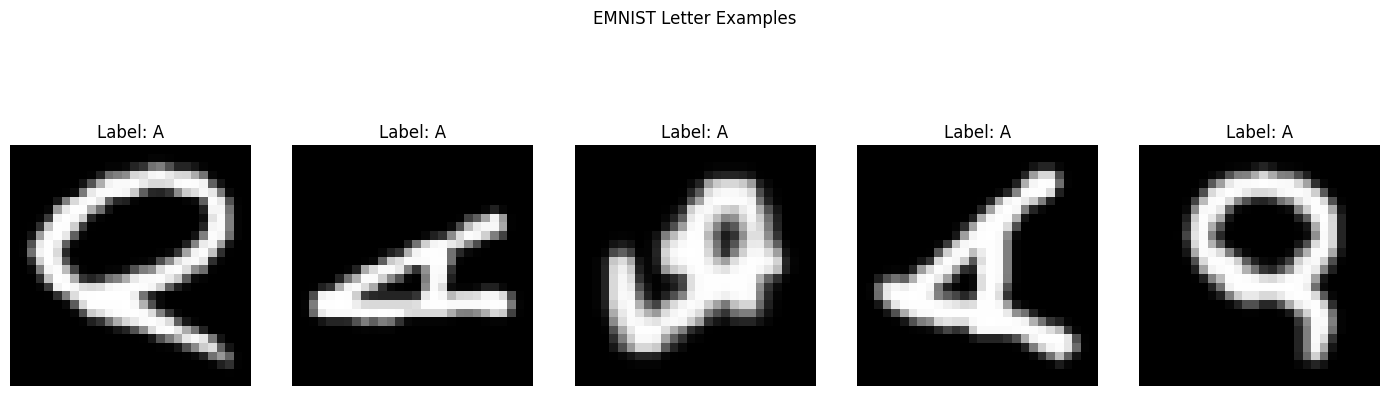

In [6]:
samples_per_class = 100  
selected_indices = []
for label in range(1, 27):
    idx = np.where(labels == label)[0][:samples_per_class]
    selected_indices.extend(idx)
selected_images = images[selected_indices]
selected_labels = labels[selected_indices]
selected_labels_char = labels_char[selected_indices]

print(f"Selected {len(selected_images)} images ({samples_per_class} per letter)")

# Visualize some example images
plt.figure(figsize=(14, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(selected_images[i], cmap='gray')
    plt.title(f"Label: {selected_labels_char[i]}")
    plt.axis('off')
plt.suptitle("EMNIST Letter Examples", y=1.1)
plt.tight_layout(w_pad=3.0)
plt.show()

**Feature Extraction with modified HOG parameters**

**Define different HOG parameter sets for comparison**

In [7]:
hog_params = [
    {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)},  # Default-like
    {'orientations': 12, 'pixels_per_cell': (6, 6), 'cells_per_block': (2, 2)}   # Modified
]

**Extract features with both parameter sets for comparison**

Extracting HOG features with parameters: {'orientations': 9, 'pixels_per_cell': (8, 8), 'cells_per_block': (3, 3)}
Extracting HOG features with parameters: {'orientations': 12, 'pixels_per_cell': (6, 6), 'cells_per_block': (2, 2)}


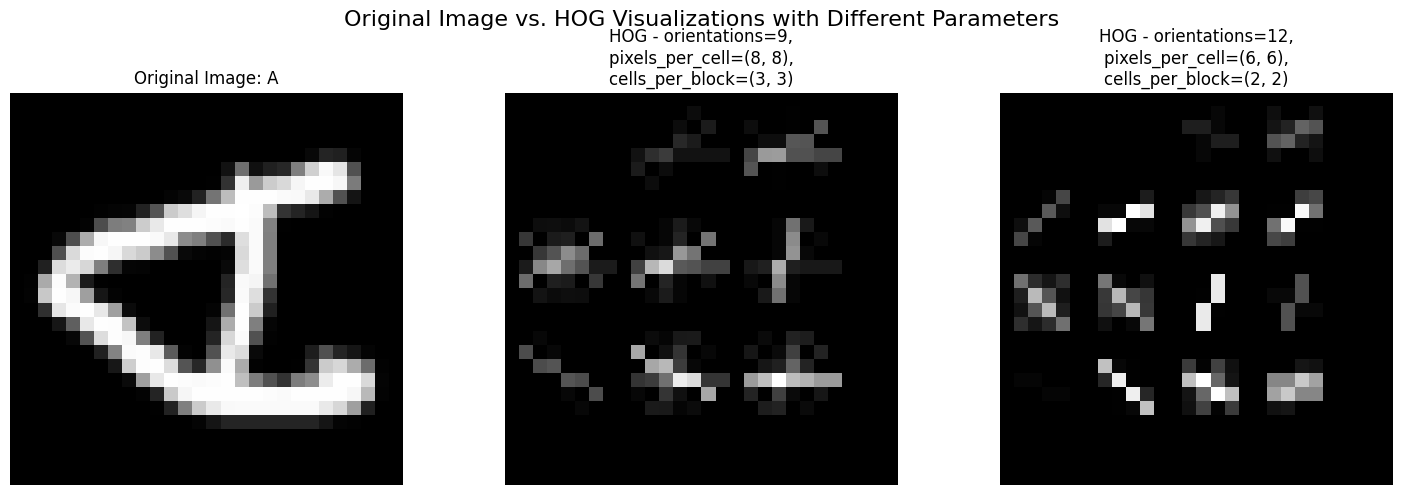

In [8]:
hog_features_sets = []
for params in hog_params:
    print(f"Extracting HOG features with parameters: {params}")
    features = []
    for img in selected_images:
        feature = hog(img, orientations=params['orientations'],
                      pixels_per_cell=params['pixels_per_cell'],
                      cells_per_block=params['cells_per_block'],
                      block_norm='L2-Hys')
        features.append(feature)
    hog_features_sets.append(np.array(features))

# Show HOG visualization for comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Original Image vs. HOG Visualizations with Different Parameters", fontsize=16)

# Original image
img_idx = 10  # Choose an index
axes[0].imshow(selected_images[img_idx], cmap='gray')
axes[0].set_title(f"Original Image: {selected_labels_char[img_idx]}")
axes[0].axis('off')

# HOG visualization with different parameters
for i, params in enumerate(hog_params):
    feature, hog_image = hog(selected_images[img_idx], 
                          orientations=params['orientations'],
                          pixels_per_cell=params['pixels_per_cell'],
                          cells_per_block=params['cells_per_block'],
                          block_norm='L2-Hys',
                          visualize=True)
    axes[i+1].imshow(hog_image, cmap='gray')
    axes[i+1].set_title(f"HOG - orientations={params['orientations']},\n" +
                       f"pixels_per_cell={params['pixels_per_cell']},\n" +
                       f"cells_per_block={params['cells_per_block']}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

# We'll use the modified parameters for our final model
hog_features = hog_features_sets[1]  # Use the modified parameters

# Scale features
scaler = StandardScaler()
hog_scaled = scaler.fit_transform(hog_features)

**Classification with SVM and Grid Search for best parameters**

**Split data into training (80%) and testing (20%)**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    hog_scaled, selected_labels, test_size=0.2, 
    random_state=42, stratify=selected_labels)

**Define parameter grid for GridSearchCV**

In [10]:
print("Performing hyperparameter search...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3],  # For poly kernel
}

Performing hyperparameter search...


Grid search to find best parameters & with best parameter

In [11]:
clf = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', cv=5, verbose=1)
clf.fit(X_train, y_train)
print("Best Parameters:", clf.best_params_)

best_svm = svm.SVC(**clf.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


**Evaluation on train and test datasets**

**Evaluate on training data**

In [12]:
best_svm.fit(X_train, y_train)
y_train_pred = best_svm.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='macro', zero_division=0)
train_recall = recall_score(y_train, y_train_pred, average='macro', zero_division=0)
train_f1 = f1_score(y_train, y_train_pred, average='macro', zero_division=0)

print("\nTraining Set Evaluation:")
print(f"Accuracy : {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall   : {train_recall:.4f}")
print(f"F1 Score : {train_f1:.4f}")


Training Set Evaluation:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000


**Evaluate on testing data**


Test Set Evaluation:
Accuracy : 0.8192
Precision: 0.8236
Recall   : 0.8192
F1 Score : 0.8184

Classification Report (Test Set):
              precision    recall  f1-score   support

           A       0.74      0.85      0.79        20
           B       0.89      0.85      0.87        20
           C       0.84      0.80      0.82        20
           D       0.75      0.90      0.82        20
           E       0.75      0.90      0.82        20
           F       0.88      0.75      0.81        20
           G       0.73      0.55      0.63        20
           H       0.88      0.75      0.81        20
           I       0.60      0.60      0.60        20
           J       0.90      0.90      0.90        20
           K       0.81      0.85      0.83        20
           L       0.74      0.70      0.72        20
           M       0.86      0.90      0.88        20
           N       0.82      0.70      0.76        20
           O       1.00      1.00      1.00        20
      

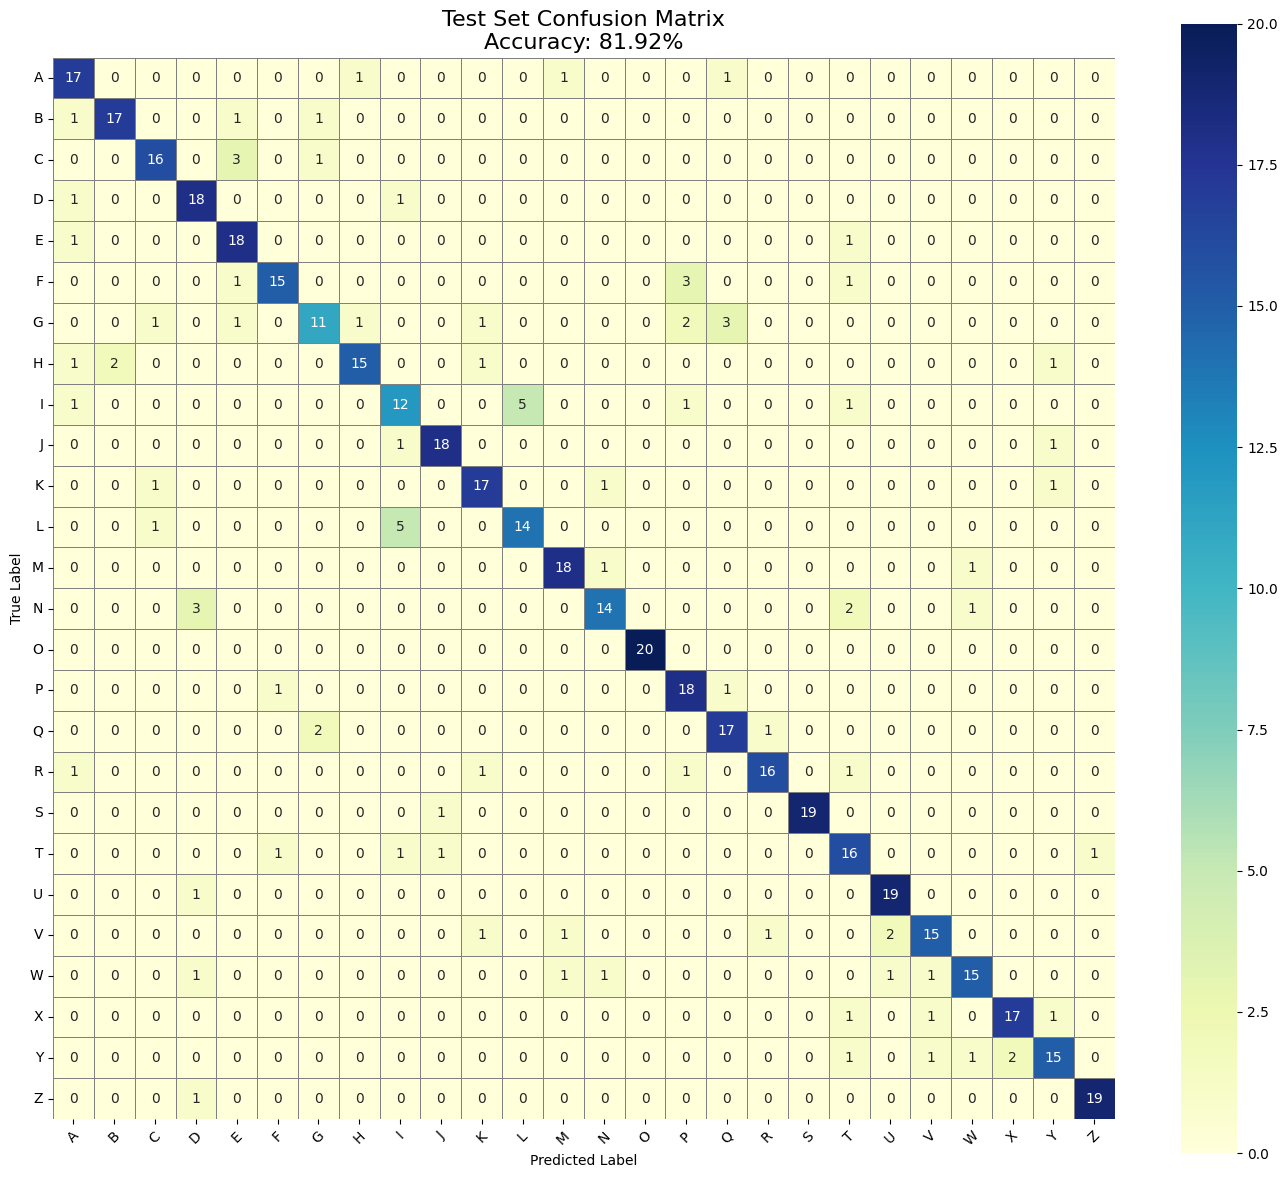

In [13]:
y_test_pred = best_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='macro', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='macro', zero_division=0)

print("\nTest Set Evaluation:")
print(f"Accuracy : {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall   : {test_recall:.4f}")
print(f"F1 Score : {test_f1:.4f}")

# Show classification report
labels_list = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=labels_list))

# Show confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=labels_list, yticklabels=labels_list, cbar=True,
            linewidths=0.5, linecolor='gray', square=True)
plt.title(f"Test Set Confusion Matrix\nAccuracy: {test_accuracy:.2%}", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**LOOCV Evaluation on a subset of the data**

In [14]:
print("\nPerforming LOOCV evaluation...")
# Select a balanced subset for LOOCV (390 samples, 15 from each class)
loocv_indices = []
for label in range(1, 27):
    label_indices = np.where(selected_labels == label)[0]
    # Choose 15 samples 
    idx = label_indices[:15]  # Take first 15 samples per class
    loocv_indices.extend(idx)

X_loo = hog_scaled[loocv_indices]
y_loo = selected_labels[loocv_indices]

# Perform LOOCV
loo = LeaveOneOut()
y_true_loo = []
y_pred_loo = []
start_time = time.time()
for train_idx, test_idx in loo.split(X_loo):
    X_tr, X_te = X_loo[train_idx], X_loo[test_idx]
    y_tr, y_te = y_loo[train_idx], y_loo[test_idx]
    best_svm.fit(X_tr, y_tr)
    pred = best_svm.predict(X_te)
    y_true_loo.append(y_te[0])
    y_pred_loo.append(pred[0])
end_time = time.time()
print(f"LOOCV took {end_time - start_time:.2f} seconds")



Performing LOOCV evaluation...
LOOCV took 10.04 seconds


**Evaluate LOOCV results & Confusion Matrix**


LOOCV Evaluation Results:
Accuracy : 0.6667
Precision: 0.6773
Recall   : 0.6667
F1 Score : 0.6668


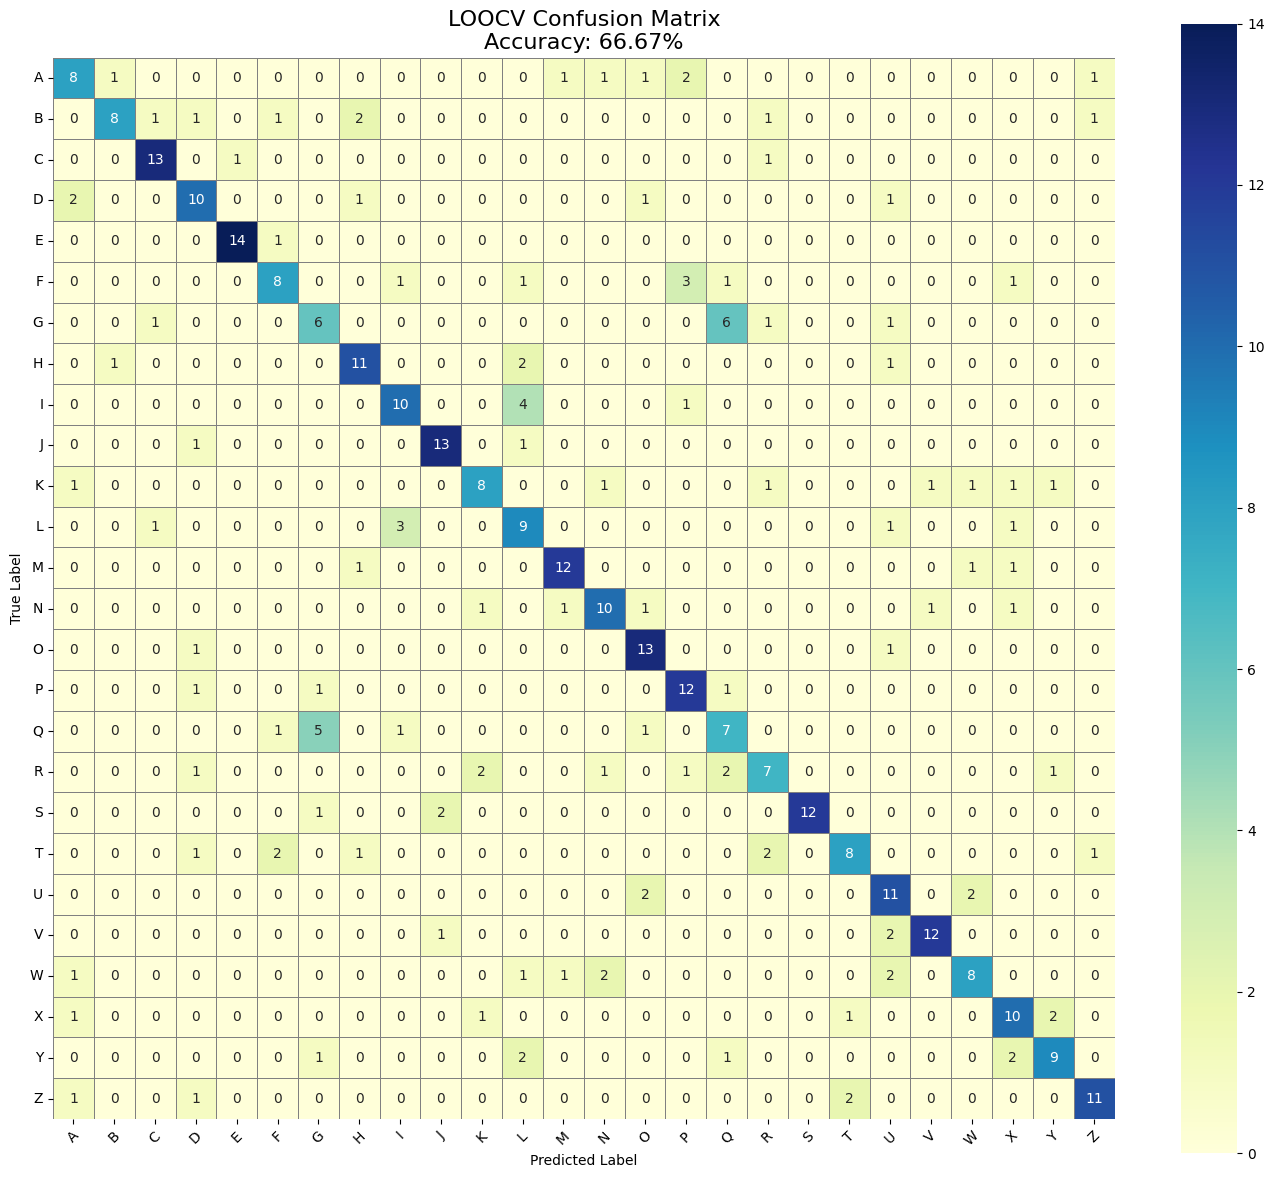

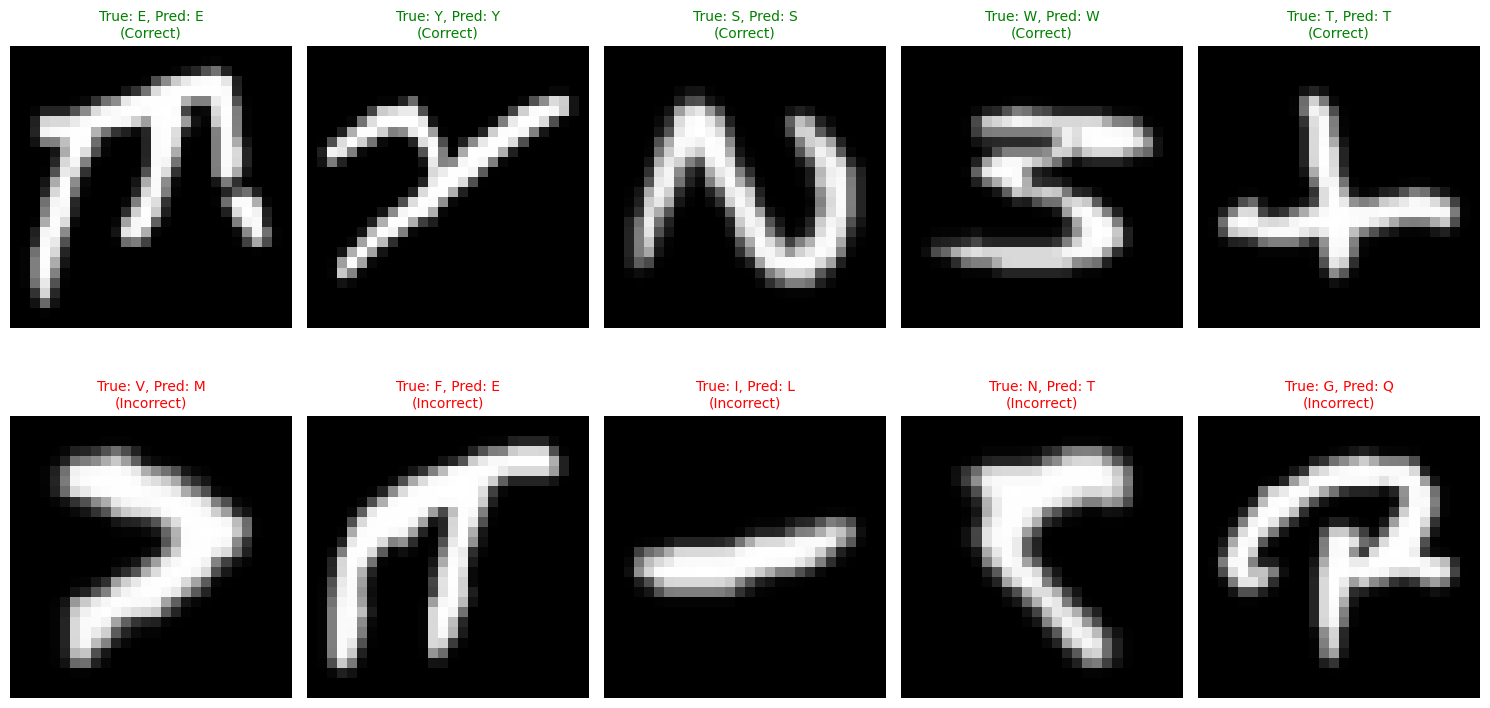

In [15]:
loocv_accuracy = accuracy_score(y_true_loo, y_pred_loo)
loocv_precision = precision_score(y_true_loo, y_pred_loo, average='macro', zero_division=0)
loocv_recall = recall_score(y_true_loo, y_pred_loo, average='macro', zero_division=0)
loocv_f1 = f1_score(y_true_loo, y_pred_loo, average='macro', zero_division=0)

print("\nLOOCV Evaluation Results:")
print(f"Accuracy : {loocv_accuracy:.4f}")
print(f"Precision: {loocv_precision:.4f}")
print(f"Recall   : {loocv_recall:.4f}")
print(f"F1 Score : {loocv_f1:.4f}")

# LOOCV Confusion Matrix
cm_loo = confusion_matrix(y_true_loo, y_pred_loo)
plt.figure(figsize=(14, 12))
sns.heatmap(cm_loo, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=labels_list, yticklabels=labels_list, cbar=True,
            linewidths=0.5, linecolor='gray', square=True)
plt.title(f"LOOCV Confusion Matrix\nAccuracy: {loocv_accuracy:.2%}", fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot some examples of correct and incorrect predictions from test set
plt.figure(figsize=(15, 8))
n_examples = 10
# Get correctly and incorrectly classified examples
correct_indices = np.where(y_test == y_test_pred)[0]
incorrect_indices = np.where(y_test != y_test_pred)[0]

for i in range(n_examples):
    plt.subplot(2, 5, i+1)
    
    if i < 5 and len(correct_indices) > i:
        # Show correctly classified examples
        idx = correct_indices[i]
        # Map back to original index
        test_idx = np.where(selected_labels == y_test[idx])[0][i % samples_per_class]
        plt.imshow(selected_images[test_idx], cmap='gray')
        plt.title(f"True: {label_map[y_test[idx]]}, Pred: {label_map[y_test_pred[idx]]}\n(Correct)", 
                 color='green', fontsize=10)
    elif i >= 5 and len(incorrect_indices) > i-5:
        # Show incorrectly classified examples  
        idx = incorrect_indices[i-5]
        # Map back to original index
        test_idx = np.where(selected_labels == y_test[idx])[0][i % samples_per_class]
        plt.imshow(selected_images[test_idx], cmap='gray')
        plt.title(f"True: {label_map[y_test[idx]]}, Pred: {label_map[y_test_pred[idx]]}\n(Incorrect)", 
                 color='red', fontsize=10)
    
    plt.axis('off')

plt.tight_layout()
plt.show()